# 二、手撕激活函数

## 1. Sigmoid
Sigmoid公式：$$\sigma(x) = \dfrac{1}{1+e^{-x}}$$

导数：$$\begin{aligned}\sigma'(x)&=\frac{e^{-x}}{1 + 2e^{-x}+e^{-2x}}\\&=\sigma(x)(1-\sigma(x))\end{aligned}$$

特性：

- 函数是单调递增，将任意实数映射到(0,1)区间，可以用来表示概率（比如在BCE中用于将原始logits分数映射成probability）
- 中心对称点在(0, 0.5)
- 在x=0附近近似线性变化，在两端趋于饱和

缺点：

- 存在梯度消失问题：在输入取值较大或较小时，梯度接近于0
- 包含指数运算，计算成本相对较高
- 在输入值较大或较小时，输出对输入的变化不敏感
- 输出不是零中心的，梯度可能就会向特定方向移动，从而降低权重更新的效率

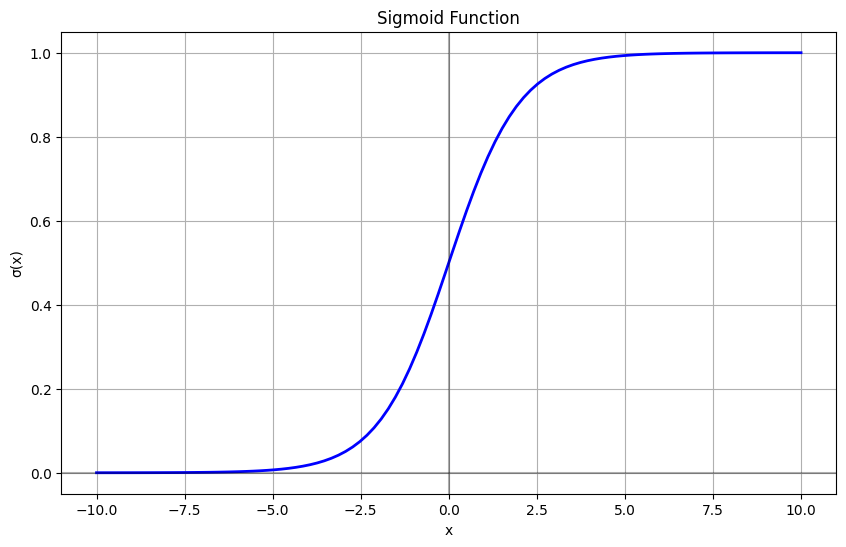

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 100)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

y = sigmoid(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2)
plt.grid(True)
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('σ(x)')

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.show()

In [19]:
import torch
from torch import nn
class MySigmoid(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

x = torch.randn(1)
torch_sigmoid = nn.Sigmoid()
my_sigmoid = MySigmoid()

print(f"Input: \t\t{x}")
print(f"Pytorch Sigmoid:{torch_sigmoid(x)}")
print(f"My Sigmoid:\t{my_sigmoid(x)}")

Input: 		tensor([-0.9606])
Pytorch Sigmoid:tensor([0.2768])
My Sigmoid:	tensor([0.2768])


## 2. Softmax
Softmax公式：$$\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$$

特性：
- 将任意实数向量映射到(0,1)区间
- 所有输出值的和为1，可以解释为概率分布

溢出问题的解决方式：softmax有指数爆炸的风险。常用的解决方法是对分子分母同除以$e^{\max(x)}$，即$$\text{Softmax}(x_i) = \frac{e^{x_i - \max(x)}}{\sum_{j=1}^n e^{x_j - \max(x)}}$$

函数示意图像：图中展示了5个输入点(-5, -2.5, 0, 2.5, 5)经过Softmax函数转换后的结果。

- 从图中可以看出，较大的输入值(x=5)获得较高的输出概率(0.918)，而较小的输入值(x=-5)获得较低的输出概率(4.17e-05)
- 所有输出概率之和为1。

[2 4 6]
[0.01587624 0.11731043 0.86681333]


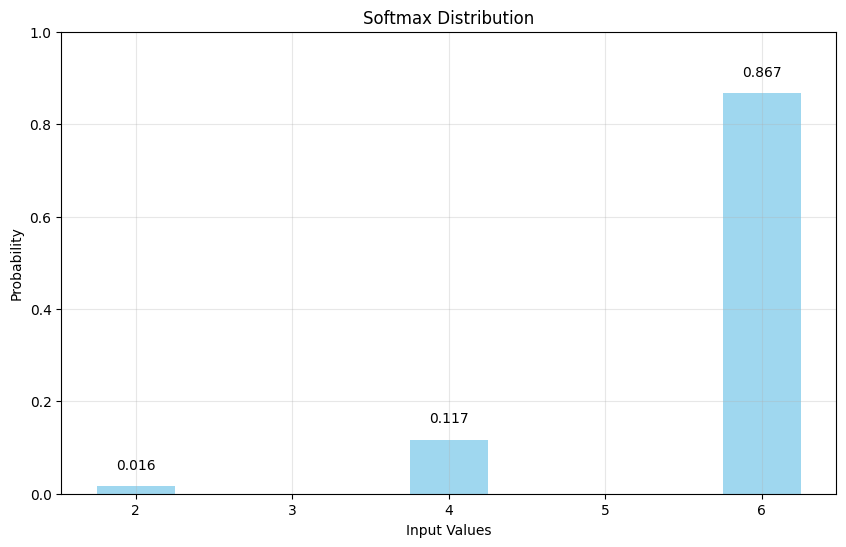

In [6]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([2, 4, 6])
print(x)

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x)

y = softmax(x)
print(y)

plt.figure(figsize=(10, 6))
plt.bar(x, y, width=0.5, alpha=0.8, color='skyblue')

# 在柱子上方添加概率值标签
for i, (x_val, y_val) in enumerate(zip(x, y)):
    plt.annotate(f'{y_val:.3f}', 
                 (x_val, y_val),
                 xytext=(0, 10),
                 textcoords='offset points', 
                 ha='center',
                 va='bottom')

plt.grid(True, alpha=0.3)
plt.title('Softmax Distribution')
plt.xlabel('Input Values')
plt.ylabel('Probability')

plt.ylim(0, 1.00)

plt.show()


In [4]:
import torch
from torch import nn
class MySoftmax(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        # 在self.dim上求最大值 且 保持输出的维度与输入相同(keepdim=True, 便于广播)
        x_max = torch.max(x, dim=self.dim, keepdim=True)[0]
        # 对分子分母同除以e^{max(x)}，以防指数爆炸
        exp_x = torch.exp(x - x_max)    # 分子
        exp_x_sum = torch.sum(exp_x, dim=self.dim, keepdim=True)    # 分母
        return exp_x / exp_x_sum
    
x = torch.tensor([[-4, 5, 8], [2, 6, 10]], dtype=torch.float32)  # shape: [2, 3]
torch_softmax = nn.Softmax(dim=1)
my_softmax = MySoftmax(dim=1)
print(f"Pytorch Softmax:\n{torch_softmax(x)}\n")
print(f"My Softmax:\n{my_softmax(x)}")

Pytorch Softmax:
tensor([[5.8528e-06, 4.7426e-02, 9.5257e-01],
        [3.2932e-04, 1.7980e-02, 9.8169e-01]])

tensor([[6.1442e-06, 4.9787e-02, 1.0000e+00],
        [3.3546e-04, 1.8316e-02, 1.0000e+00]])
tensor([[1.0498],
        [1.0187]])
tensor([[5.8528e-06, 4.7426e-02, 9.5257e-01],
        [3.2932e-04, 1.7980e-02, 9.8169e-01]])
My Softmax:
tensor([[5.8528e-06, 4.7426e-02, 9.5257e-01],
        [3.2932e-04, 1.7980e-02, 9.8169e-01]])


## 3. Tanh
Tanh公式：$$\tanh(x) = \dfrac{e^x-e^{-x}}{e^x+e^{-x}}$$

导数：$$\tanh'(x) = 1-\tanh^2(x)$$

特性：
- 函数是单调递增，将任意实数映射到(-1,1)区间，中心对称点在(0, 0)
- 在x=0附近近似线性变化，在两端趋于饱和

缺点：
- 两端梯度弥散：在输入取值较大或较小时，梯度接近于0（同Sigmoid）
- 包含指数运算，计算成本相对较高（同Sigmoid）

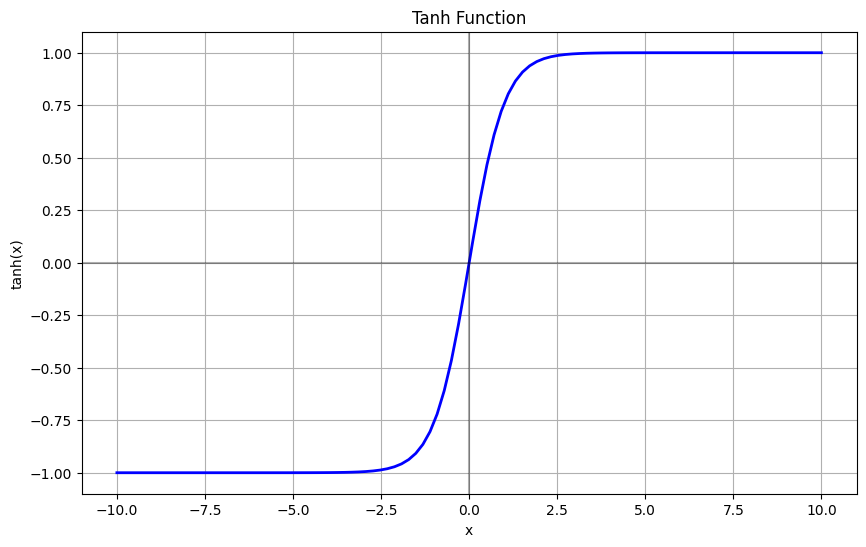

In [9]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 100)

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

y = tanh(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2)
plt.grid(True)
plt.title('Tanh Function')
plt.xlabel('x')
plt.ylabel('tanh(x)')

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.show()

In [15]:
import torch
from torch import nn

class MyTanh(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

x = torch.randn(1)
torch_tanh = nn.Tanh()
my_tanh = MyTanh()

print(f"Input: \t\t{x}")
print(f"Pytorch Tanh: \t{torch_tanh(x)}")
print(f"My Tanh: \t{my_tanh(x)}")

Input: 		tensor([-1.0334])
Pytorch Tanh: 	tensor([-0.7753])
My Tanh: 	tensor([-0.7753])


## 4. ReLU
ReLU公式：$$\text{ReLU}(x) = \max(0, x)$$

导数：$$\text{ReLU}'(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{if } x \leq 0 \end{cases}$$

特性：
- 单侧抑制，负半轴值被置为0
- 解决了梯度消失的问题，当输入值为正时，神经元不会饱和（梯度始终为 1）
- 只需判断是否大于0，计算复杂度低，不需要进行指数运算

缺点：
- 死亡ReLU问题：如果一个神经元的输入总是为负，那么梯度永远为0，神经元将永远不会更新
- 输出不是零中心的

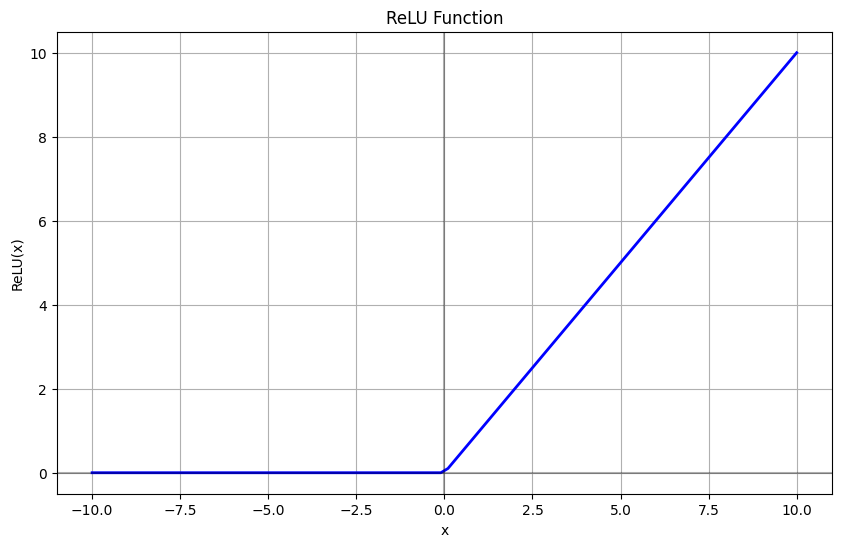

In [20]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 100)

def relu(x):
    return np.maximum(0, x)

y = relu(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2)
plt.grid(True)
plt.title('ReLU Function')
plt.xlabel('x')
plt.ylabel('ReLU(x)')

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.show()


In [28]:
import torch
from torch import nn
class MyReLU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.max(torch.tensor(0, dtype=torch.float32), x)
    
x = torch.tensor([2.5, -2.5])
torch_relu = nn.ReLU()
my_relu = MyReLU()

print(f"Input1: \t{x}")
print(f"Pytorch ReLU: \t{torch_relu(x)}")
print(f"My ReLU: \t{my_relu(x)}")

Input1: 	tensor([ 2.5000, -2.5000])
Pytorch ReLU: 	tensor([2.5000, 0.0000])
My ReLU: 	tensor([2.5000, 0.0000])


## 5. Leaky ReLU
Leaky ReLU公式：$$\text{LeakyReLU}(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha x & \text{if } x \leq 0 \end{cases}$$其中 $\alpha$ 是一个小的正数（通常为0.01）

导数：$$\text{LeakyReLU}'(x) = \begin{cases} 1 & \text{if } x > 0 \\ \alpha & \text{if } x \leq 0 \end{cases}$$

特性：
- 是ReLU的改进版本，保留了ReLU的大部分优点
- 相比ReLU，Leaky ReLU在负区间给予一个很小的斜率，因此所有输入值都有非零的梯度，避免了Dead ReLU问题
- 计算简单，只需要一个分段线性函数

缺点：
- 输出仍然不是零中心的

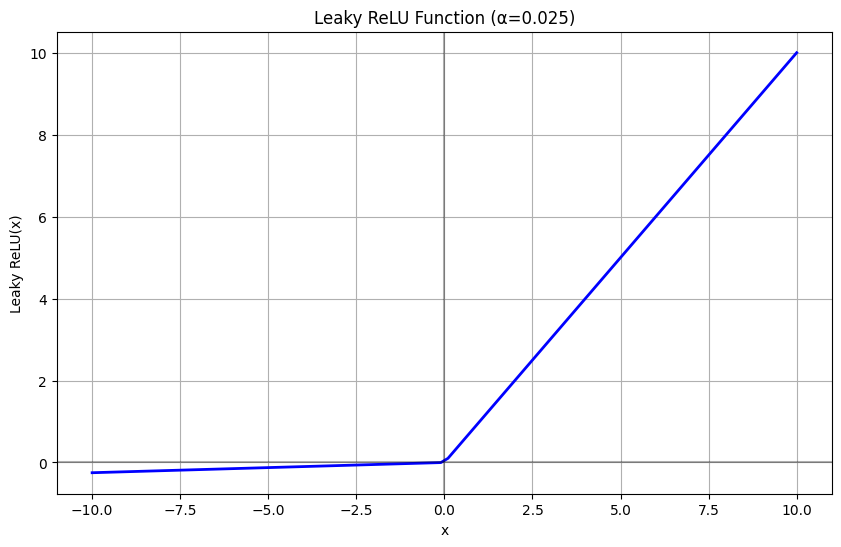

In [40]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 100)
alpha = 0.025 

def leaky_relu(x):
    return np.where(x > 0, x, alpha * x)

y = leaky_relu(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2)
plt.grid(True)
plt.title(f'Leaky ReLU Function (α={alpha})')
plt.xlabel('x')
plt.ylabel('Leaky ReLU(x)')

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)


plt.show()

In [39]:
import torch
from torch import nn
class MyLeakyReLU(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
    def forward(self, x):
        return torch.where(x > 0, x, self.alpha * x)

x = torch.tensor([2.5, -2.5])
alpha = 0.01
torch_leakyrelu = nn.LeakyReLU(alpha)
my_leakyrelu = MyLeakyReLU(alpha)

print(f"Input: \t\t\t{x}")
print(f"Pytorch LeakyReLU: \t{torch_leakyrelu(x)}")
print(f"My LeakyReLU: \t\t{my_leakyrelu(x)}")

Input: 			tensor([ 2.5000, -2.5000])
Pytorch LeakyReLU: 	tensor([ 2.5000, -0.0250])
My LeakyReLU: 		tensor([ 2.5000, -0.0250])


## 6. ELU
ELU公式：$$\text{ELU}(x) = \begin{cases} x & \text{if } x > 0 \\ \alpha(e^x - 1) & \text{if } x \leq 0 \end{cases}$$其中 $\alpha$ 是一个正数（通常为1.0）

导数：$$\text{ELU}'(x) = \begin{cases} 1 & \text{if } x > 0 \\ \alpha e^x & \text{if } x \leq 0 \end{cases}$$

特性：

- ELU 采用比 ReLU 更平滑的过渡，保持负区间微小梯度解决神经元死亡问题
- 在负区间使用指数函数，使得输出均值更接近零，有助于缓解梯度消失问题，并提高学习效率

缺点：

- 包含指数运算，计算成本比ReLU和Leaky ReLU高

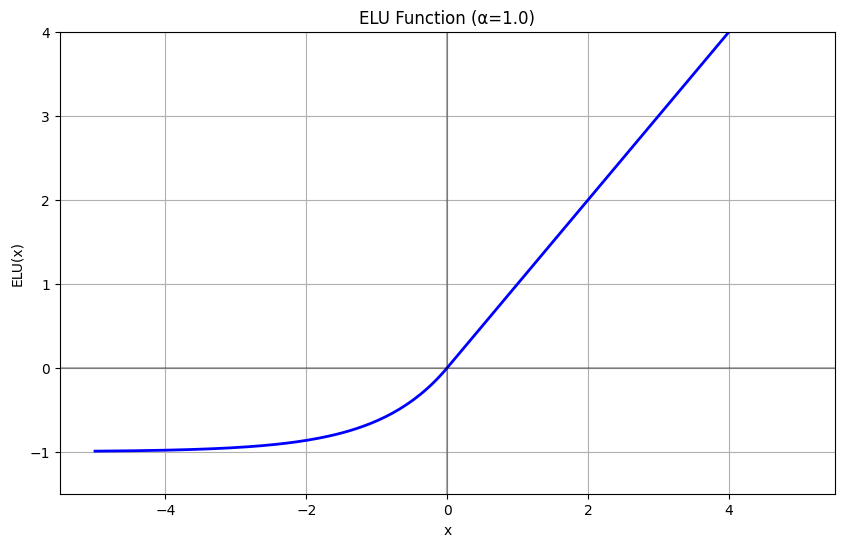

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 200)
alpha = 1.0

def elu(x):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

y = elu(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', linewidth=2)
plt.grid(True)
plt.title(f'ELU Function (α={alpha})')
plt.xlabel('x')
plt.ylabel('ELU(x)')

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.ylim(-1.5, 4)
plt.show()

In [2]:
import torch
from torch import nn

class MyELU(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
    def forward(self, x):
        return torch.where(x > 0, x, self.alpha * torch.exp(x) - self.alpha)

x = torch.tensor([2.5, -2.5])
alpha = 1.0
torch_elu = nn.ELU(alpha)
my_elu = MyELU(alpha)

print(f"Input: \t\t{x}")
print(f"Pytorch ELU: \t{torch_elu(x)}")
print(f"My ELU: \t{my_elu(x)}")

Input: 		tensor([ 2.5000, -2.5000])
Pytorch ELU: 	tensor([ 2.5000, -0.9179])
My ELU: 	tensor([ 2.5000, -0.9179])


## 7. Swish
> 由Google Brain团队在2017年提出, arXiv Link：[Searching for Activation Functions](https://arxiv.org/abs/1710.05941)

Swish公式：$$\text{Swish}(x) = x \cdot \sigma(\beta x)$$其中 $\sigma(x)$ 是 Sigmoid 函数，$\beta$ 是可学习或固定的参数（当 $\beta=1$ 时称为 SiLU）

导数：$$\begin{aligned}\text{Swish}'(x) &=\sigma(\beta x) + x\sigma'(\beta x)\\&=\sigma(\beta x) + \beta x\cdot\sigma(\beta x)(1 - \sigma(\beta x))\\&=\sigma(\beta x) + \beta x\cdot[\sigma(\beta x)-\sigma^2(\beta x)]\\&=\beta x\cdot\sigma(\beta x) + \sigma(\beta x)\cdot(1 - \beta x \cdot \sigma(\beta x))\\&= \beta \cdot \text{Swish}(x) + \sigma(\beta x)(1 - \beta \cdot \text{Swish}(x))\end{aligned}$$

特性：

- 是一个平滑的非单调函数，在负值区域也能保持一定的梯度
- 处处可微，在全体实数域上连续可导
- 通过调整$\beta$值，Swish可以模拟不同形状
- 实验证明，在深层网络中Swish的表现优于ReLU

缺点：

- 计算复杂度比ReLU高，需要计算Sigmoid
- 在某些情况下，性能提升可能不足以弥补额外的计算成本

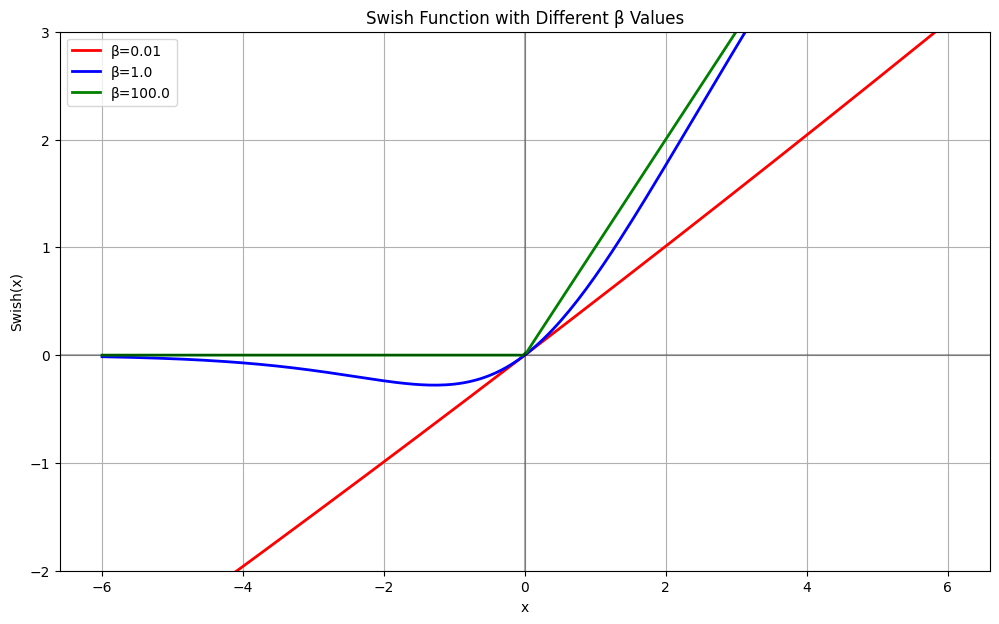

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def swish(x, beta):
    return x * sigmoid(beta * x)

x = np.linspace(-6, 6, 200)
betas = [0.01, 1.0, 100.0]
colors = ['r', 'b', 'g']  # 红、绿、蓝三种颜色

plt.figure(figsize=(12, 7))

# 画Swish函数
for beta, color in zip(betas, colors):
    y = swish(x, beta)
    plt.plot(x, y, color=color, linewidth=2, label=f'β={beta}')


# 添加坐标轴
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.grid(True)
plt.title('Swish Function with Different β Values')
plt.xlabel('x')
plt.ylabel('Swish(x)')
plt.legend()


plt.ylim(-2, 3)
plt.show()

- 当 $\beta \to 0$ 时，Swish 趋近于线性函数 $\frac{x}{2}$（如上图红色曲线）
- 当$\beta\rightarrow\infty$ 时，$\text{Swish}(x)=\begin{cases} x & \text{if } x > 0 \\ 0 & \text{if } x \leq 0 \end{cases}=\max(x,\,0)$，趋近于ReLU（如上图绿色曲线）

In [13]:
import torch
from torch import nn

class MySwish(nn.Module):
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
    def forward(self, x):
        sigmoid_betax = 1 / (1 + torch.exp(-1 * self.beta * x))
        return x * sigmoid_betax
    
x = torch.randn(1)
beta = 1.0
torch_swish = nn.SiLU() # beta = 1
my_swish = MySwish(beta)

print(f"Input: \t\t{x}")
print(f"Pytorch Swish: \t{torch_swish(x)}")
print(f"My Swish: \t{my_swish(x)}")

Input: 		tensor([-0.9684])
Pytorch Swish: 	tensor([-0.2665])
My Swish: 	tensor([-0.2665])


## 8. GeLU
GeLU公式：$$\begin{aligned}\text{GeLU}(x) &= x \cdot \Phi(x)\\&\approx 0.5x\left(1 + \tanh\left(\sqrt{2/\pi}(x + 0.044715x^3)\right)\right)\end{aligned}$$其中$\Phi(x)$是标准正态分布的累积分布函数(CDF)

>在实践中，通常使用近似公式来计算GeLU，因为精确计算标准正态分布的CDF在计算上较为昂贵。
>
>高斯误差函数(erf): $\text{erf}(x) = \frac{2}{\sqrt{\pi}}\int_0^x e^{-t^2}dt$
>
>标准正态分布的CDF: $\Phi(x) = \frac{1}{2}[1 + \text{erf}(\frac{x}{\sqrt{2}})]$
>
>标准正态分布的PDF: $\phi(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$


导数：$$\text{GeLU}'(x) = \Phi(x) + x\phi(x)$$其中$\phi(x)$是标准正态分布的概率密度函数(PDF)

特性：
- 是一个平滑的非线性函数，且处处可微
- 在x为负时会有一定程度的抑制，但不会完全置零，避免 ReLU 的神经元死亡问题
- 在大型语言模型中表现优异，如BERT、GPT等都使用了GeLU

缺点：
- 计算复杂度较高

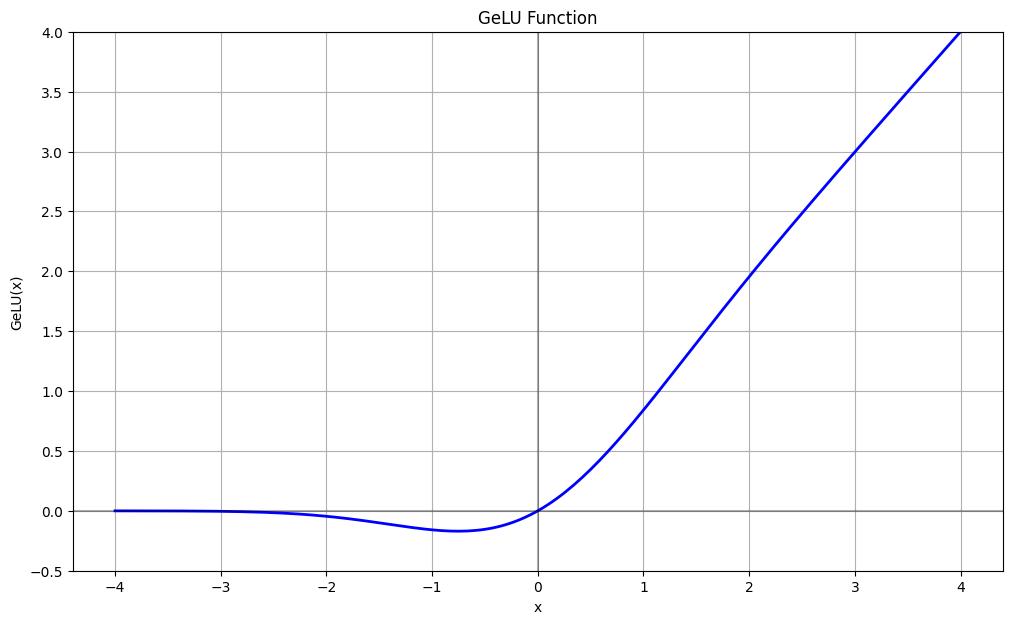

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def gelu_exact(x):
    return x * norm.cdf(x)

x = np.linspace(-4, 4, 200)
y_exact = gelu_exact(x)

plt.figure(figsize=(12, 7))

plt.plot(x, y_exact, 'b-', linewidth=2)


plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.grid(True)
plt.title('GeLU Function')
plt.xlabel('x')
plt.ylabel('GeLU(x)')

plt.ylim(-0.5, 4)
plt.show()

In [29]:
import torch
from torch import nn
import math

class MyTanh(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

class MyGeLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.k = 0.044715
        self.tanh = MyTanh()
    def forward(self, x):
        tanh = self.tanh(math.sqrt(2 / math.pi) * (x + self.k * x**3))
        return 0.5 * x * (1 + tanh)

x = torch.randn(1)
torch_gelu = nn.GELU()
my_gelu = MyGeLU()

print(f"Input: \t\t{x}")
print(f"Pytorch GELU: \t{torch_gelu(x)}")
print(f"My GELU: \t{my_gelu(x)}")

Input: 		tensor([0.7185])
Pytorch GELU: 	tensor([0.5488])
My GELU: 	tensor([0.5487])


## 9. SwiGLU
> 由谷歌研究团队在2022年提出，用于PaLM语言模型，arXiv Link：[PaLM: Scaling Language Modeling with Pathways](https://arxiv.org/abs/2204.02311)

SwiGLU公式：$$\mathrm{SwiGLU}(x)=\mathrm{Swish}_{\beta=1}(Wx+b)\otimes Vx$$其中$\otimes$表示逐元素相乘

常和FFN组合使用：$$\mathrm{FFN}_{\mathrm{SwiGLU}}=W_2\left(\mathrm{Swish}_{\beta=1}(W_1x+b_1)\otimes(Vx)\right)+b_2$$

特性：

- 结合了Swish和GLU(Gated Linear Unit)的特点，通过门控机制可以更好地控制信息流动
- 在大型语言模型中表现优异，如LLama、PaLM使用SwiGLU替代ReLU/GeLU获得了更好的性能

缺点：

- 计算复杂度较高

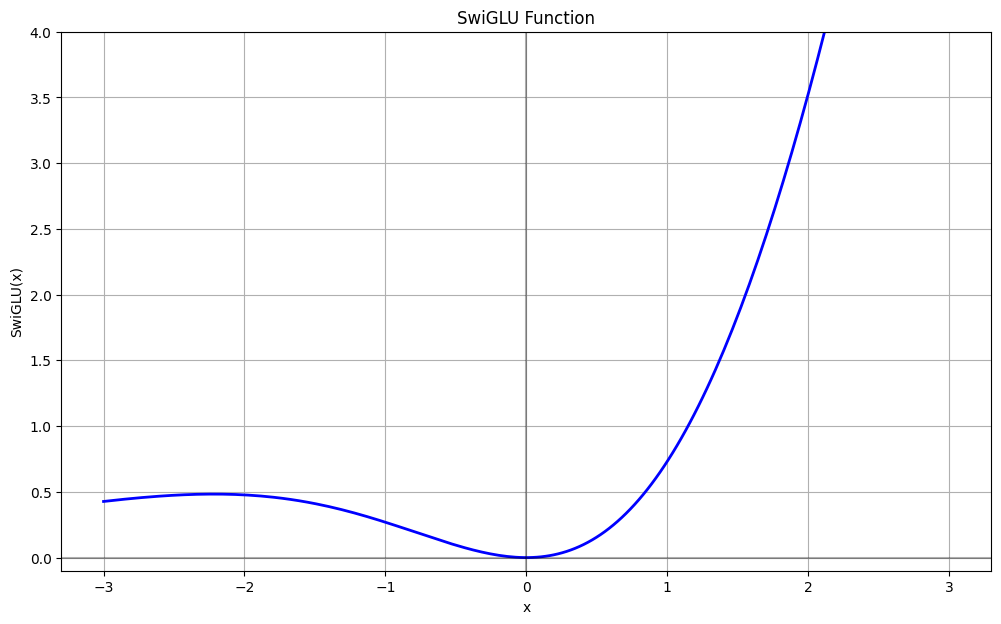

In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def swiglu(x, W=1.0, V=1.0, b=0.0):
    return F.silu(W * x + b) * (V * x)

x_range = torch.linspace(-3, 3, 200)

with torch.no_grad():
    y_swiglu = swiglu(x_range)

plt.figure(figsize=(12, 7))
plt.plot(x_range.numpy(), y_swiglu.numpy(), 'b-', linewidth=2)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.grid(True)
plt.title('SwiGLU Function')
plt.xlabel('x')
plt.ylabel('SwiGLU(x)')
plt.ylim(-0.1, 4)
plt.show()


In [44]:
import torch
from torch import nn

class MySwish(nn.Module):
    def __init__(self, beta=1):
        super().__init__()
        self.beta = beta
    def forward(self, x):
        sigmoid_beta = 1 / (1 + torch.exp(-1 * self.beta * x))
        return x * sigmoid_beta

class MySwiGLU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.W1 = nn.Linear(input_size, hidden_size, bias=True)
        self.V = nn.Linear(input_size, hidden_size, bias=False)
        self.W2 = nn.Linear(hidden_size, input_size, bias=True)
        self.swish = MySwish(beta=1)
    def forward(self, x):
        gate = self.swish(self.W1(x))
        value = self.V(x)
        return self.W2(gate * value)

input_size = 128
hidden_size = 128
batch_size = 2
x = torch.randn(batch_size, input_size)
my_swiglu = MySwiGLU(input_size, input_size)